In [25]:
print("""This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports""")

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
from copy import deepcopy

In [27]:
RUN_BASELINE_ONLY = False
image_mode = False
debug_mode = False

drop_percentages = [0.2, 0.35, 0.5, 0.65, 0.75]
number_of_generated_subgraphs = 5000
baseline_file = "experiment_1"

In [28]:
results = {}
nodes_results = {} 
total_nodes_dict = {}
avg_total_nodes_results = {}
baseline_success = None

In [29]:
for i, drop_pct in enumerate(drop_percentages):
    # The baseline does not change since there are no nodes dropped
    # so i wait for the first iteration to finish to create the first basline.log file
    # then i extract the baseline from that logfile once and let the iterations finish
    if i == 1:
        if os.path.exists(baseline_file+'.log'):
            with open(baseline_file+'.log', 'r') as f:
                content = f.read()
            baseline_match = re.search(r'Attacker can guarantee success probability of: ([0-9.]+)', content)
            if baseline_match:
                baseline_success = float(baseline_match.group(1))
            print(f"Baseline attacker success: {baseline_success}")

    print(f"\n{'='*50}")
    print(f"RUNNING EXPERIMENT WITH DROP PERCENTAGE: {drop_pct*100}%")
    print(f"{'='*50}\n")
    
    # Set variables that will be accessible in the experiment notebook
    experiment_name = f"experiment_drop_{int(drop_pct*100)}"
    
    # Set the drop hyperpar. and run the experiment
    # extrapol_pct = drop_pct
    # this will run the experiment file
    # which in turn will run 1) subgraph generation 2) ctr-core
    %run "{baseline_file}.ipynb"
    
    # Extract average success from subgraph analysis
    subgraph_file = f"sub_{baseline_file}.log"
    if os.path.exists(subgraph_file):
        with open(subgraph_file, 'r') as f:
            content = f.read()
        avg_match = re.search(r'Average attacker success across subgraphs: ([0-9.]+)', content)
        nodes_match = re.search(r'Initial number of dropped nodes per subgraph: ([0-9]+)', content)
        avg_total_nodes_match = re.search(r'Average total nodes dropped \(including cleanup\): ([0-9.]+)', content)
        total_nodes_match = re.search(r'Total number of nodes in the graph: ([0-9]+)', content)

        if avg_match:
            avg_success = float(avg_match.group(1))
            #results[drop_pct] = avg_success
            results[drop_pct] = round(avg_success, 3)
            diff = avg_success - baseline_success if baseline_success else "N/A"
            print(f"Drop %: {drop_pct*100}%, Avg Success: {avg_success}, Diff: {diff}")

        if nodes_match:
            dropped_nodes = int(nodes_match.group(1))
            nodes_results[drop_pct] = dropped_nodes
            print(f"Number of dropped nodes per subgraph: {dropped_nodes}")

        if avg_total_nodes_match and total_nodes_match:
            avg_total_nodes = float(avg_total_nodes_match.group(1))
            total_nodes = int(total_nodes_match.group(1))
            avg_total_nodes_results[drop_pct] = avg_total_nodes
        
        if avg_total_nodes_match and total_nodes_match:
            avg_total_nodes = float(avg_total_nodes_match.group(1))
            total_nodes = int(total_nodes_match.group(1))
            avg_total_nodes_results[drop_pct] = avg_total_nodes
            total_nodes_dict[drop_pct] = total_nodes  

    else:
        print(f"Warning: Could not find subgraph log file")


RUNNING EXPERIMENT WITH DROP PERCENTAGE: 20.0%

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports
Current settings: image_mode=False, debug_mode=False, RUN_BASELINE_ONLY=False
create subsgraph for defender concluded
We start with the baseline graph calculation!
Now we are going to run the subgraph analysis
The subgraph analysis is done!
[1] "experiment_1.log"
[1] "Tue Mar 25 13:57:45 2025"



BASELINE RUN: BOTH ATTACKER AND DEFENDER HAVE FULL GRAPH KNOWLEDGE



++++++++++++++++++++++++++++++++

The virtual target nodeID is c(6,9)

attack rate =  2 , defense rate =  0 

	equilibrium for multiobjective security game (MOSG)

optimal defense strategy:
         prob.
2 0.000000e+00
3 2.798527e-01
4 2.798527e-01
5 0.000000e+00
7 0.000000e+00
8 4.402946e-01

worst case attack strategies per goal:
          1
1 0.3600737
2 0.3600737
3 0.2798527
[1] 0.128

Defender can keep attacker success below: 0.128
Attack

In [30]:
# Create DataFrame
df = pd.DataFrame({
    'Drop Percentage': [k*100 for k in results.keys()],
    'Dropped Nodes': [nodes_results.get(k, float('nan')) for k in results.keys()],
    'Avg Total Nodes Dropped': [avg_total_nodes_results.get(k, float('nan')) for k in results.keys()],
    'Actual Drop Percentage': [avg_total_nodes_results.get(k, float('nan'))/total_nodes_dict.get(k, 17)*100 for k in results.keys()],
    'Average Success': list(results.values()),
    'Baseline': [baseline_success] * len(results),
    'Difference': [results[k] - baseline_success for k in results.keys()]
})

# Print dataframe here to read
# Store it in some external .csv file for potential later use
print("\nFinal Results:")
print(df)
df.to_csv(f'{baseline_file}_extrapolation_results.csv', index=False)


Final Results:
   Drop Percentage  Dropped Nodes  Avg Total Nodes Dropped  \
0             20.0              1                     1.57   
1             35.0              2                     2.89   
2             50.0              3                     4.20   
3             65.0              4                     5.24   
4             75.0              5                     6.02   

   Actual Drop Percentage  Average Success  Baseline  Difference  
0               17.444444            0.161     0.128       0.033  
1               32.111111            0.187     0.128       0.059  
2               46.666667            0.203     0.128       0.075  
3               58.222222            0.208     0.128       0.080  
4               66.888889            0.214     0.128       0.086  


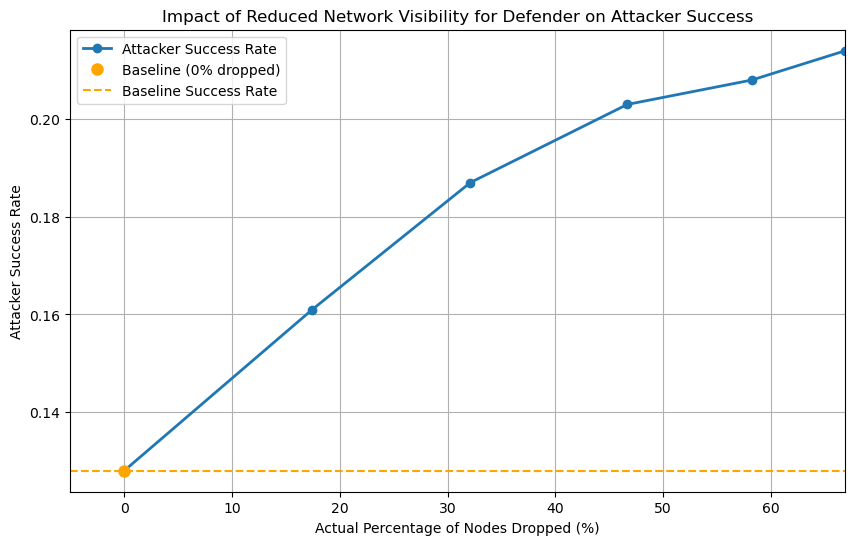

In [31]:
# Plot results
plt.figure(figsize=(10, 6))

# Combine baseline with the rest of the data for a continuous line
all_drop_percentages = [0] + list(df['Actual Drop Percentage'])  # Changed to Actual Drop Percentage
all_success_rates = [baseline_success] + list(df['Average Success'])

# Plot the connected line with all points
plt.plot(all_drop_percentages, all_success_rates, 'o-', linewidth=2, label='Attacker Success Rate')

# Highlight baseline point
plt.plot(0, baseline_success, 'o', color='orange', markersize=8, label='Baseline (0% dropped)')

# Add horizontal baseline line
plt.axhline(y=baseline_success, color='orange', linestyle='--', label='Baseline Success Rate')

# Set x-axis to start at 0
plt.xlim(-5, max(all_drop_percentages))

plt.xlabel('Actual Percentage of Nodes Dropped (%)')  # Updated label
plt.ylabel('Attacker Success Rate')
plt.title('Impact of Reduced Network Visibility for Defender on Attacker Success')
plt.legend()
plt.grid(True)
plt.savefig(f'{baseline_file}_plot.png')
plt.show()